In [267]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay


In [268]:
df = pd.read_csv('train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [269]:
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

print("Numerical Features:", numerical_features)
print("Categorical Features:", categorical_features)

Numerical Features: ['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
Categorical Features: ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']


In [270]:
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Coloane': missing_values.index,
    'Missing Values': missing_values.values,
    'Percentage': missing_percent.values
})
missing_df = missing_df[missing_df['Percentage'] > 0].sort_values('Percentage', ascending=False)

print(missing_df.to_string(index=False))

 Coloane  Missing Values  Percentage
   Cabin             687   77.104377
     Age             177   19.865320
Embarked               2    0.224467


In [271]:
print(f"Shape before dropping: {df.shape}")
df = df.drop(['Cabin', 'Age', 'Ticket', 'Name', 'PassengerId'], axis=1)
print(f"Shape after dropping: {df.shape}")
print(f"\nRemaining features: {df.columns.tolist()}")

Shape before dropping: (891, 12)
Shape after dropping: (891, 7)

Remaining features: ['Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked']


In [272]:
remaining_missing = df.isnull().sum()
remaining_missing = remaining_missing[remaining_missing > 0]
if len(remaining_missing) > 0:
    print("Remaining missing values:")
    print(remaining_missing)
else:
    print("No missing values remaining")

Remaining missing values:
Embarked    2
dtype: int64


In [273]:
print(f"Shape before removing Embarked nulls: {df.shape}")
df = df.dropna(subset=['Embarked'])
print(f"Shape after removing Embarked nulls: {df.shape}")

Shape before removing Embarked nulls: (891, 7)
Shape after removing Embarked nulls: (889, 7)


In [274]:
survival_counts = df['Survived'].value_counts()
died = survival_counts.get(0, 0)
survived = survival_counts.get(1, 0)
total = len(df)
survival_rate = df['Survived'].mean()

print(f"Survived (1): {survived} ({survived/total*100:.1f}%)")
print(f"Died (0): {died} ({died/total*100:.1f}%)")
print(f"Overall Survival Rate: {survival_rate:.2%}")


Survived (1): 340 (38.2%)
Died (0): 549 (61.8%)
Overall Survival Rate: 38.25%


In [275]:
gender_survival = pd.crosstab(df['Sex'], df['Survived'], normalize='index') * 100
print(f"Females had a survival rate of {gender_survival.loc['female', 1]:.1f}%")
print(f"Males had a survival rate of {gender_survival.loc['male', 1]:.1f}%")

Females had a survival rate of 74.0%
Males had a survival rate of 18.9%


In [276]:
class_survival = pd.crosstab(df['Pclass'], df['Survived'], normalize='index') * 100
print("Key Observation: Higher class passengers had better survival rates")
for pclass in [1, 2, 3]:
    print(f"Class {pclass}: {class_survival.loc[pclass, 1]:.1f}% survival rate")

Key Observation: Higher class passengers had better survival rates
Class 1: 62.6% survival rate
Class 2: 47.3% survival rate
Class 3: 24.2% survival rate


In [277]:
survival_by_class_sex = pd.crosstab([df['Sex'], df['Pclass']], df['Survived'], normalize='index') * 100
for sex in ['female', 'male']:
    print(f"{sex.upper()}:")
    for pclass in [1, 2, 3]:
        survived_rate = survival_by_class_sex.loc[(sex, pclass), 1]
        died_rate = survival_by_class_sex.loc[(sex, pclass), 0]
        print(f"  Class {pclass}: Survived {survived_rate:.1f}% | Died {died_rate:.1f}%")
    print()

FEMALE:
  Class 1: Survived 96.7% | Died 3.3%
  Class 2: Survived 92.1% | Died 7.9%
  Class 3: Survived 50.0% | Died 50.0%

MALE:
  Class 1: Survived 36.9% | Died 63.1%
  Class 2: Survived 15.7% | Died 84.3%
  Class 3: Survived 13.5% | Died 86.5%



In [278]:
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

alone = df['IsAlone'].sum()
with_family = len(df) - alone
total = len(df)

alone_survived = df[df['IsAlone']==1]['Survived'].sum()
alone_died = df[df['IsAlone']==1]['Survived'].count() - alone_survived
alone_total = df['IsAlone'].sum()

family_survived = df[df['IsAlone']==0]['Survived'].sum()
family_died = df[df['IsAlone']==0]['Survived'].count() - family_survived
family_total = len(df) - alone_total

print(f"\nPASSENGERS ALONE ({alone_total} total):")
print(f"  Survived:  {alone_survived} ({alone_survived/alone_total*100:.1f}%)")
print(f"  Died:      {alone_died} ({alone_died/alone_total*100:.1f}%)")

print(f"\nPASSENGERS WITH FAMILY ({family_total} total):")
print(f"  Survived:  {family_survived} ({family_survived/family_total*100:.1f}%)")
print(f"  Died:      {family_died} ({family_died/family_total*100:.1f}%)")

alone_survival_rate = alone_survived / alone_total * 100
family_survival_rate = family_survived / family_total * 100

print(f"  \nAlone survival rate:  {alone_survival_rate:.1f}%")
print(f"Family survival rate: {family_survival_rate:.1f}%")




PASSENGERS ALONE (535 total):
  Survived:  161 (30.1%)
  Died:      374 (69.9%)

PASSENGERS WITH FAMILY (354 total):
  Survived:  179 (50.6%)
  Died:      175 (49.4%)
  
Alone survival rate:  30.1%
Family survival rate: 50.6%


### 1. **Gender Impact** 
- **Females: 74.0% survival rate** - 3 out of 4 women survived
- **Males: 18.9% survival rate** - Only 1 out of 5 men survived
- The "Women and children first" evacuation protocol was clearly followed
- **Gender was the strongest predictor of survival**

### 2. **Class Impact**
Passenger class had a dramatic effect on survival chances:
- **First Class: 62.6% survived** - Better access to lifeboats
- **Second Class: 47.3% survived** - Moderate survival rate  
- **Third Class: 24.2% survived** - Limited access to upper decks

### 3. **Gender + Class Combined Effect**
The intersection of gender and class reveals stark inequalities:

**Females:**
- 1st Class: **96.7%** survived (almost all)
- 2nd Class: **92.1%** survived (vast majority)
- 3rd Class: **50.0%** survived (half survived)

**Males:**
- 1st Class: **36.9%** survived (only 1 in 3)
- 2nd Class: **15.7%** survived (1 in 6)
- 3rd Class: **13.5%** survived (1 in 7)

**Key Finding:** Being a 1st class female gave you the best chance (96.7%), while being a 3rd class male gave you the worst (13.5%)

### 4. **Family Status Impact**
- **Traveling alone: 30.1% survival rate** (161 out of 535)
- **With family: 50.6% survival rate** (179 out of 354)
- **20.5 percentage point difference** - families helped each other survive



In [279]:
target = "Survived"
X = df.drop(columns=[target])
Y = df[target]
numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
print("Numerical Features:", numerical_features)
print("Categorical Features:", categorical_features)

Numerical Features: ['Pclass', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'IsAlone']
Categorical Features: ['Sex', 'Embarked']


In [280]:
numerical_pipeline = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5))
])

categorical_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y_encoded, test_size=0.3, random_state=42)

In [281]:
preprocessor = ColumnTransformer([
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
])

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Model Training


In [282]:
decision_tree_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42, max_depth=5))
])

decision_tree_pipeline.fit(X_train, Y_train)
Y_predicted = decision_tree_pipeline.predict(X_test)
decision_tree_accuracy = accuracy_score(Y_test, Y_predicted)
print(f"Accuracy: {decision_tree_accuracy:.4f} ({decision_tree_accuracy*100:.2f}%)")
print(classification_report(Y_test, Y_predicted, target_names=['Died', 'Survived']))

Accuracy: 0.7678 (76.78%)
              precision    recall  f1-score   support

        Died       0.79      0.86      0.82       167
    Survived       0.73      0.61      0.66       100

    accuracy                           0.77       267
   macro avg       0.76      0.74      0.74       267
weighted avg       0.76      0.77      0.76       267



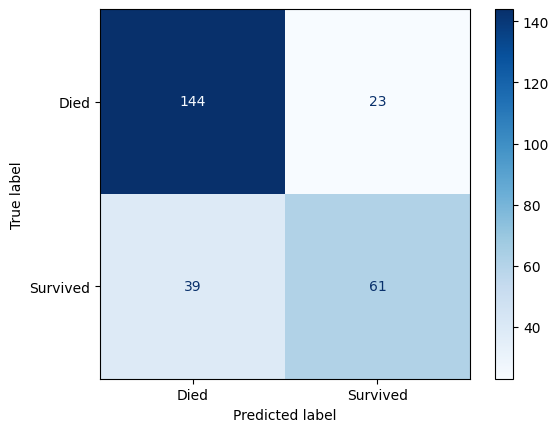

In [283]:
cm_decision_tree = confusion_matrix(Y_test, Y_predicted)
ConfusionMatrixDisplay(confusion_matrix=cm_decision_tree, display_labels=['Died', 'Survived']).plot(cmap='Blues')
plt.show()

In [284]:

random_forest_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, max_depth=5))
])

random_forest_pipeline.fit(X_train, Y_train)
Y_predicted = random_forest_pipeline.predict(X_test)
random_forest_accuracy = accuracy_score(Y_test, Y_predicted)
print(f"Accuracy: {random_forest_accuracy:.4f} ({random_forest_accuracy*100:.2f}%)")
print(classification_report(Y_test, Y_predicted, target_names=['Died', 'Survived']))

Accuracy: 0.7903 (79.03%)
              precision    recall  f1-score   support

        Died       0.81      0.87      0.84       167
    Survived       0.76      0.65      0.70       100

    accuracy                           0.79       267
   macro avg       0.78      0.76      0.77       267
weighted avg       0.79      0.79      0.79       267



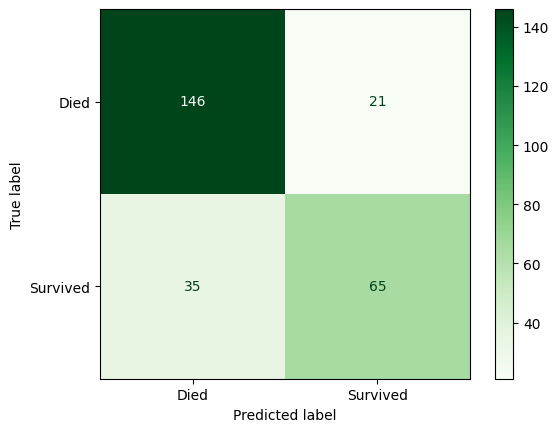

In [285]:
cm_random_forest = confusion_matrix(Y_test, Y_predicted)
ConfusionMatrixDisplay(confusion_matrix=cm_random_forest, display_labels=['Died', 'Survived']).plot(cmap='Greens')
plt.show()

## **Model Performance Comparison Across Different Train/Test Splits**

| **Test Size** | **Model**     | **Accuracy** | **Recall (Died)** | **Recall (Survived)** | **Notes**                                             |
| ------------: | ------------- | :----------: | :---------------: | :-------------------: | ----------------------------------------------------- |
|       **20%** | Decision Tree |  **79.21%**  |      **0.89**     |          0.64         | Stronger on predicting **Died**                       |
|       **20%** | Random Forest |    78.65%    |        0.83       |        **0.72**       | More **balanced** performance                         |
|       **30%** | Decision Tree |    76.78%    |      **0.86**     |          0.61         | Performance drops with less training data             |
|       **30%** | Random Forest |  **79.03%**  |        0.87       |        **0.65**       | More stable with less data                            |
|       **35%** | Decision Tree |  **80.13%**  |      **0.91**     |          0.64         | Best DT performance when given **more training data** |
|       **35%** | Random Forest |    79.49%    |        0.86       |        **0.69**       | Still more balanced overall                           |

---

